In [1]:
# 🛠️ Step 1: Install dependencies
!pip install gluonts mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 80.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have 

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Cluster files.zip to Cluster files.zip


In [2]:
import zipfile
import os

# Replace 'your_folder.zip' with the actual name of your zip file
zip_path = '/content/Cluster files.zip'
extract_path = 'Cluster_Files'  # This will be the folder name after extraction

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Optional: list contents to confirm
print("Contents:")
print(os.listdir(extract_path))


Contents:
['Cluster files']


In [3]:
# -------------------- PART 1: SHARED DEEPAR MODEL (LEAKAGE FIXED) --------------------

import os
import pandas as pd
import numpy as np
import json
from gluonts.dataset.common import ListDataset
from gluonts.mx.trainer import Trainer
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.distribution import StudentTOutput
from gluonts.evaluation.backtest import make_evaluation_predictions

# Parameters
DATA_FOLDER = "/content/Cluster_Files/Cluster files"
freq = "D"
prediction_length = 30
context_length = 60
ma_window = 7
epochs = 30
learning_rate = 5e-4

train_series = []
residual_windows = []

# -------- STEP 1: Aggregate data for all clusters --------
for cluster_id in range(10):
    file_path = os.path.join(DATA_FOLDER, f"cluster_{cluster_id}.csv")
    if not os.path.exists(file_path):
        print(f"Missing file: {file_path}")
        continue

    df = pd.read_csv(file_path)
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
    df["date"] = df["InvoiceDate"].dt.date
    daily = df.groupby("date")["TotalSales"].sum().reset_index()
    daily["date"] = pd.to_datetime(daily["date"]).sort_values()

    # Moving average target
    daily["MovingAvgSales"] = daily["TotalSales"].rolling(window=ma_window, min_periods=1).mean()
    sales = daily["MovingAvgSales"].values

    # ✅ FIX 1: Compute min/max only on training data
    train_sales = sales[:-prediction_length]
    min_val, max_val = train_sales.min(), train_sales.max()
    scaled_sales = (sales - min_val) / (max_val - min_val + 1e-8)

    # Time features
    dates = daily["date"]
    day_of_week = dates.dt.dayofweek / 6.0
    month = (dates.dt.month - 1) / 11.0
    rolling = pd.Series(scaled_sales).rolling(window=7, min_periods=1).mean().values

    # Static features
    avg_sales = np.mean(sales)
    std_sales = np.std(sales)
    zero_ratio = np.sum(sales == 0) / len(sales)

    # Split
    train_target = scaled_sales[:-prediction_length]
    test_target = sales[-prediction_length:]
    start_date = daily["date"].iloc[0]

    train_series.append({
        "start": start_date,
        "target": train_target.tolist(),
        "feat_static_real": [avg_sales, std_sales, zero_ratio],
        "feat_dynamic_real": [
            day_of_week.values[:-prediction_length].tolist(),
            month.values[:-prediction_length].tolist(),
            rolling[:-prediction_length].tolist()
        ],
        "cluster_id": cluster_id,
        "test_target": test_target.tolist(),
        "unscaled_meta": [min_val, max_val],
        "rolling": rolling[-prediction_length:].tolist(),
        "day_of_week": day_of_week.values[-prediction_length:].tolist(),
        "month": month.values[-prediction_length:].tolist()
    })

# -------- STEP 2: Train ONE shared DeepAR model --------
shared_ds = ListDataset(
    [{
        "start": entry["start"],
        "target": entry["target"],
        "feat_static_real": entry["feat_static_real"],
        "feat_dynamic_real": entry["feat_dynamic_real"]
    } for entry in train_series],
    freq=freq
)

estimator = DeepAREstimator(
    freq=freq,
    prediction_length=prediction_length,
    context_length=context_length,
    num_cells=30,
    num_layers=1,
    dropout_rate=0.1,
    cell_type="gru",
    distr_output=StudentTOutput(),
    use_feat_dynamic_real=True,
    use_feat_static_real=True,
    trainer=Trainer(epochs=epochs, learning_rate=learning_rate),
)

predictor = estimator.train(training_data=shared_ds)

# -------- STEP 3: Forecast per cluster using the shared model --------
for entry in train_series:
    single_ds = ListDataset([{
        "start": entry["start"],
        "target": entry["target"],
        "feat_static_real": entry["feat_static_real"],
        "feat_dynamic_real": entry["feat_dynamic_real"]
    }], freq=freq)

    forecast_it, _ = make_evaluation_predictions(
        dataset=single_ds, predictor=predictor, num_samples=100
    )

    forecast = list(forecast_it)[0]
    pred_scaled = forecast.mean
    min_val, max_val = entry["unscaled_meta"]
    unscaled_pred = pred_scaled * (max_val - min_val + 1e-8) + min_val
    residual = np.array(entry["test_target"]) - unscaled_pred

    residual_windows.append({
        "cluster": entry["cluster_id"],
        "deepar_pred": unscaled_pred.tolist(),
        "actual": entry["test_target"],
        "residual": residual.tolist()
    })

# -------- STEP 4: Save residuals --------
with open("residual_windows.json", "w") as f:
    json.dump(residual_windows, f)

print("✅ Saved residual_windows.json — Ready for Transformer")

100%|██████████| 50/50 [00:06<00:00,  7.38it/s, epoch=30/30, avg_epoch_loss=-1.44]


✅ Saved residual_windows.json — Ready for Transformer/PatchTST


Epoch 1, Loss: 4.8914
  Cluster 0 Avg Loss: 3.1071
  Cluster 1 Avg Loss: 4.1109
  Cluster 2 Avg Loss: 1.9945
  Cluster 3 Avg Loss: 4.4250
  Cluster 4 Avg Loss: 6.3245
  Cluster 5 Avg Loss: 8.2686
  Cluster 6 Avg Loss: 16.6406
  Cluster 7 Avg Loss: 3.3294
  Cluster 8 Avg Loss: 1.4034
  Cluster 9 Avg Loss: 2.9928
Epoch 2, Loss: 4.1241
  Cluster 0 Avg Loss: 2.9416
  Cluster 1 Avg Loss: 2.8849
  Cluster 2 Avg Loss: 1.2933
  Cluster 3 Avg Loss: 3.8376
  Cluster 4 Avg Loss: 5.3503
  Cluster 5 Avg Loss: 7.0024
  Cluster 6 Avg Loss: 16.1185
  Cluster 7 Avg Loss: 2.3188
  Cluster 8 Avg Loss: 1.3645
  Cluster 9 Avg Loss: 2.7654
Epoch 3, Loss: 4.0460
  Cluster 0 Avg Loss: 2.2595
  Cluster 1 Avg Loss: 2.2138
  Cluster 2 Avg Loss: 1.1854
  Cluster 3 Avg Loss: 3.0689
  Cluster 4 Avg Loss: 5.1128
  Cluster 5 Avg Loss: 6.0791
  Cluster 6 Avg Loss: 15.2694
  Cluster 7 Avg Loss: 1.9621
  Cluster 8 Avg Loss: 1.6663
  Cluster 9 Avg Loss: 1.8279
Epoch 4, Loss: 4.4405
  Cluster 0 Avg Loss: 1.6064
  Cluster 

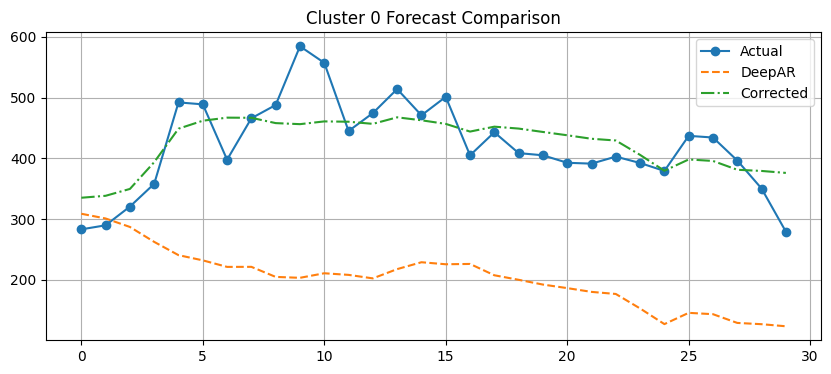

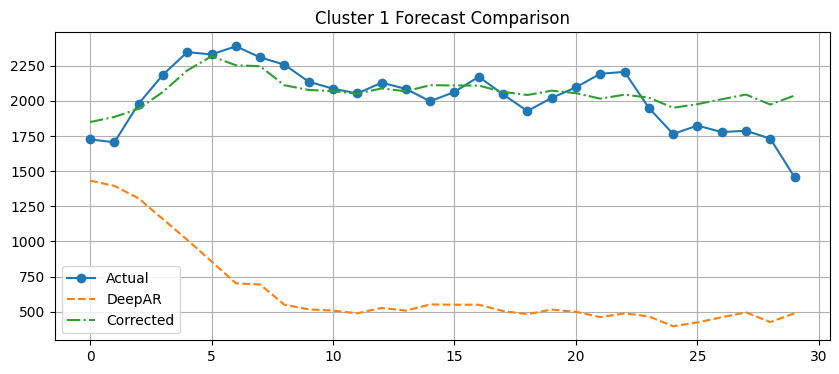

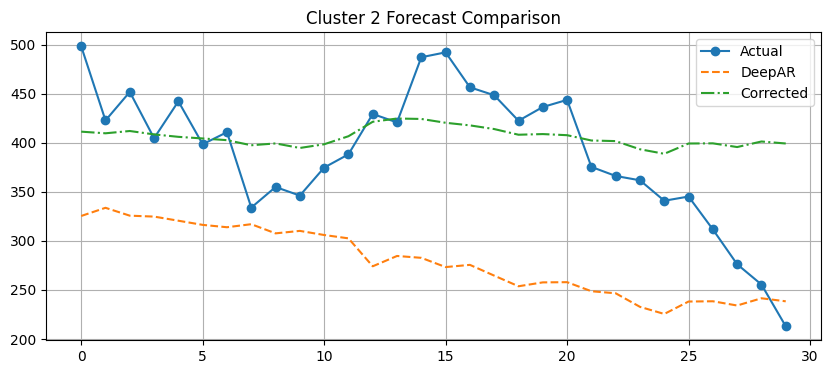

In [19]:
# -------------------- FINAL TRANSFORMER MODEL WITH IMPROVEMENTS --------------------

import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_percentage_error

# -------------------- Dataset --------------------

with open("residual_windows.json", "r") as f:
    data = json.load(f)

class ResidualDataset(nn.Module):
    def __init__(self, data):
        self.X, self.y, self.clusters, self.means, self.stds = [], [], [], [], []
        for d in data:
            if len(d["deepar_pred"]) == 30 and len(d["residual"]) == 30:
                x = np.array(d["deepar_pred"])
                y = np.array(d["residual"])
                x_mean, x_std = x.mean(), x.std() + 1e-8
                self.X.append((x - x_mean) / x_std)
                self.y.append(y / x_std)
                self.clusters.append(d["cluster"])
                self.means.append(x_mean)
                self.stds.append(x_std)
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)
        self.clusters = torch.tensor(self.clusters, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx], self.clusters[idx]

dataset = ResidualDataset(data)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# -------------------- Positional Encoding --------------------

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=30):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# -------------------- Transformer with Cluster Embedding --------------------

class ResidualTransformerMTFinal(nn.Module):
    def __init__(self, seq_len=30, d_model=48, nhead=4, num_layers=2, num_clusters=10):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        self.cluster_embed = nn.Embedding(num_embeddings=num_clusters, embedding_dim=d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.15, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x, cluster_id):
        x = x.unsqueeze(-1)
        x = self.input_proj(x)
        cluster_vec = self.cluster_embed(cluster_id).unsqueeze(1)
        x = x + cluster_vec
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = self.norm(x)
        x = self.dropout(x)
        return self.output_proj(x).squeeze(-1)

# -------------------- Training --------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mt_final = ResidualTransformerMTFinal().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(mt_final.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

mt_final.train()
for epoch in range(100):
    total_loss = 0
    cluster_losses = {i: [] for i in range(10)}
    for batch_x, batch_y, batch_c in dataloader:
        batch_x, batch_y, batch_c = batch_x.to(device), batch_y.to(device), batch_c.to(device)
        optimizer.zero_grad()
        output = mt_final(batch_x, batch_c)
        loss = criterion(output, batch_y)
        loss.backward()
        nn.utils.clip_grad_norm_(mt_final.parameters(), 1.0)
        optimizer.step()
        for i, c in enumerate(batch_c.tolist()):
            cluster_losses[c].append(criterion(output[i], batch_y[i]).item())
        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")
    for k, v in cluster_losses.items():
        if v:
            print(f"  Cluster {k} Avg Loss: {np.mean(v):.4f}")

# -------------------- Evaluation --------------------

mt_final.eval()
corrected_mapes = {}

for d in data:
    x_raw = np.array(d["deepar_pred"])
    x_mean, x_std = x_raw.mean(), x_raw.std() + 1e-8
    x_input = torch.tensor((x_raw - x_mean) / x_std, dtype=torch.float32).unsqueeze(0).to(device)
    cluster_id = torch.tensor([d["cluster"]], dtype=torch.long).to(device)
    with torch.no_grad():
        correction = mt_final(x_input, cluster_id).squeeze(0).cpu().numpy() * x_std
    corrected_forecast = x_raw + correction
    actual = np.array(d["actual"])
    mape = mean_absolute_percentage_error(actual, corrected_forecast)
    corrected_mapes[f"Cluster {d['cluster']}"] = round(mape * 100, 2)

print("\n\U0001F4CA Final MAPE after Transformer Residual Correction (mt_final):")
for cluster, mape in sorted(corrected_mapes.items()):
    print(f"{cluster}: {mape}%")

# -------------------- Visualization --------------------

for d in data[:3]:
    x_raw = np.array(d["deepar_pred"])
    x_mean, x_std = x_raw.mean(), x_raw.std() + 1e-8
    x_input = torch.tensor((x_raw - x_mean) / x_std, dtype=torch.float32).unsqueeze(0).to(device)
    cluster_id = torch.tensor([d["cluster"]], dtype=torch.long).to(device)
    with torch.no_grad():
        correction = mt_final(x_input, cluster_id).squeeze(0).cpu().numpy() * x_std
    corrected = x_raw + correction
    plt.figure(figsize=(10, 4))
    plt.plot(d["actual"], label="Actual", marker='o')
    plt.plot(d["deepar_pred"], label="DeepAR", linestyle='--')
    plt.plot(corrected, label="Corrected", linestyle='-.')
    plt.title(f"Cluster {d['cluster']} Forecast Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
import json

with open("residual_windows.json", "r") as f:
    full_data = json.load(f)

# Keep only entries for cluster 5 and 6
filtered_data = [d for d in full_data if d["cluster"] in [5, 6]]

with open("residual_windows_c56.json", "w") as f:
    json.dump(filtered_data, f)

print(f"✅ Saved residual_windows_c56.json with {len(filtered_data)} samples.")

✅ Saved residual_windows_c56.json with 2 samples.


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import json

# Load filtered data
with open("residual_windows_c56.json", "r") as f:
    data = json.load(f)

scale_factor = 10000.0

# Dataset
class ResidualDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.X, self.y, self.clusters = [], [], []
        for d in data:
            if len(d["deepar_pred"]) == 30 and len(d["residual"]) == 30:
                self.X.append(np.array(d["deepar_pred"]) / scale_factor)
                self.y.append(np.array(d["residual"]) / scale_factor)
                self.clusters.append(d["cluster"])
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)
        self.clusters = torch.tensor(self.clusters, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx], self.clusters[idx]

dataset = ResidualDataset(data)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=30):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x): return x + self.pe[:, :x.size(1)]

# Transformer Model
class ResidualTransformerC56(nn.Module):
    def __init__(self, seq_len=30, d_model=64, nhead=4, num_layers=3, num_clusters=10):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        self.cluster_embed = nn.Embedding(num_embeddings=num_clusters, embedding_dim=d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x, cluster_id):  # x: (B, T)
        x = x.unsqueeze(-1)  # (B, T, 1)
        x = self.input_proj(x)  # (B, T, d_model)
        cluster_vec = self.cluster_embed(cluster_id).unsqueeze(1)  # (B, 1, d_model)
        x = x + cluster_vec
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = self.norm(x)
        return self.output_proj(x).squeeze(-1)

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mt_c56 = ResidualTransformerC56().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(mt_c56.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80)

mt_c56.train()
for epoch in range(80):
    total_loss = 0
    for batch_x, batch_y, batch_c in dataloader:
        batch_x, batch_y, batch_c = batch_x.to(device), batch_y.to(device), batch_c.to(device)
        optimizer.zero_grad()
        out = mt_c56(batch_x, batch_c)
        loss = criterion(out, batch_y)
        loss.backward()
        nn.utils.clip_grad_norm_(mt_c56.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

Epoch 1, Loss: 0.4360
Epoch 2, Loss: 0.3879
Epoch 3, Loss: 0.3307
Epoch 4, Loss: 0.2451
Epoch 5, Loss: 0.2186
Epoch 6, Loss: 0.1629
Epoch 7, Loss: 0.1309
Epoch 8, Loss: 0.1185
Epoch 9, Loss: 0.1053
Epoch 10, Loss: 0.0899
Epoch 11, Loss: 0.0722
Epoch 12, Loss: 0.0537
Epoch 13, Loss: 0.0406
Epoch 14, Loss: 0.0337
Epoch 15, Loss: 0.0301
Epoch 16, Loss: 0.0328
Epoch 17, Loss: 0.0312
Epoch 18, Loss: 0.0218
Epoch 19, Loss: 0.0287
Epoch 20, Loss: 0.0265
Epoch 21, Loss: 0.0285
Epoch 22, Loss: 0.0261
Epoch 23, Loss: 0.0197
Epoch 24, Loss: 0.0310
Epoch 25, Loss: 0.0286
Epoch 26, Loss: 0.0265
Epoch 27, Loss: 0.0266
Epoch 28, Loss: 0.0162
Epoch 29, Loss: 0.0217
Epoch 30, Loss: 0.0174
Epoch 31, Loss: 0.0219
Epoch 32, Loss: 0.0181
Epoch 33, Loss: 0.0216
Epoch 34, Loss: 0.0212
Epoch 35, Loss: 0.0175
Epoch 36, Loss: 0.0184
Epoch 37, Loss: 0.0200
Epoch 38, Loss: 0.0202
Epoch 39, Loss: 0.0142
Epoch 40, Loss: 0.0179
Epoch 41, Loss: 0.0143
Epoch 42, Loss: 0.0152
Epoch 43, Loss: 0.0156
Epoch 44, Loss: 0.01

In [27]:
# Evaluation
mt_c56.eval()
mapes_c56 = {}

for d in data:
    x_input = torch.tensor(d["deepar_pred"], dtype=torch.float32).unsqueeze(0).to(device) / scale_factor
    cluster_id = torch.tensor([d["cluster"]], dtype=torch.long).to(device)
    with torch.no_grad():
        correction = mt_c56(x_input, cluster_id).squeeze(0).cpu().numpy() * scale_factor
    corrected = np.array(d["deepar_pred"]) + correction
    actual = np.array(d["actual"])
    mape = mean_absolute_percentage_error(actual, corrected)
    mapes_c56[f"Cluster {d['cluster']}"] = round(mape * 100, 2)

print("\n📊 Fine-Tuned MAPE for Clusters 5 & 6:")
for cluster, mape in sorted(mapes_c56.items()):
    print(f"{cluster}: {mape}%")


📊 Fine-Tuned MAPE for Clusters 5 & 6:
Cluster 5: 9.23%
Cluster 6: 193.84%


In [34]:
final_predictions = {}
mt_final.eval()
mt_c56.eval()

scale_factor = 10000.0  # Consistent with mt_c56 training

for d in data:
    cluster = d["cluster"]
    cluster_tensor = torch.tensor([cluster], dtype=torch.long).to(device)

    if cluster == 5:
        # Use scale-factor based scaling for mt_c56
        x_input = torch.tensor(d["deepar_pred"], dtype=torch.float32).unsqueeze(0).to(device) / scale_factor
        with torch.no_grad():
            correction = mt_c56(x_input, cluster_tensor).squeeze(0).cpu().numpy() * scale_factor
    else:
        # Use z-score scaling for mt_final
        x_raw = np.array(d["deepar_pred"])
        x_mean, x_std = x_raw.mean(), x_raw.std() + 1e-8
        x_input = torch.tensor((x_raw - x_mean) / x_std, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            correction = mt_final(x_input, cluster_tensor).squeeze(0).cpu().numpy() * x_std
        x_raw = np.array(d["deepar_pred"])

    # For both models, add correction to raw predictions
    corrected = np.array(d["deepar_pred"]) + correction
    actual = np.array(d["actual"])
    mape = mean_absolute_percentage_error(actual, corrected)
    final_predictions[f"Cluster {cluster}"] = round(mape * 100, 2)

print("\n📊 Final MAPE with mt_c56 (for cluster 5) and mt_final (for others):")
for c, v in sorted(final_predictions.items()):
    print(f"{c}: {v}%")


📊 Final MAPE with mt_c56 (for cluster 5) and mt_final (for others):
Cluster 0: 9.53%
Cluster 1: 6.48%
Cluster 2: 14.47%
Cluster 3: 11.0%
Cluster 4: 19.66%
Cluster 5: 9.23%
Cluster 6: 47.62%
Cluster 7: 6.44%
Cluster 8: 11.12%
Cluster 9: 8.85%
